In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

# 1. Data Load

In [2]:
train_data_dir = '/opt/ml/input/data/train'

# 2. EDA: train_rating.csv

- \# of unique users: 31360
- \# of unique items: 6807
- 결측치(null값)은 없다.
- Sparsity ratio: 0.976
    - 일반적인 추천 시스템 데이터셋에 비해 굉장히 dense한 (행렬 상 이력의 많은 부분이 채워져 있는) 데이터임을 알 수 있다.
- 가장 적게 평점을 매긴 user: 53188 (16)

In [3]:
ratings_df = pd.read_csv(os.path.join(train_data_dir, 'train_ratings.csv'))

ratings_df.sample(10)

,user,item,time
2063568,54612,51540,1341592177
32241,847,3342,1116286582
406064,10876,103042,1376580771
2927262,78173,608,1147064113
259774,6776,7090,1332451087
4610497,123392,7502,1302765107
3622614,96647,1333,1233501121
914799,24183,4270,1296614204
4720470,126569,150,1264277060
11352,367,4226,1145050067


In [42]:
num_train_users = ratings_df['user'].nunique()
num_train_items = ratings_df['item'].nunique()

print("Number of unique train users: ", num_train_users)
print("Number of unique train items: ", num_train_items)
print(f"\nMissing vluae: \n{ratings_df.isnull().sum()}")
print("\nData sparsity ratio: ", 1 - len(ratings_df) / (num_train_users * num_train_items))
print(ratings_df.value_counts(subset='user', sort=True))


Number of unique train users:  31360
Number of unique train items:  6807

Missing vluae: 
user    0
item    0
time    0
dtype: int64

Data sparsity ratio:  0.9758536052697853
user
8405      2912
54465     1980
24219     1842
32514     1830
91349     1795
          ... 
11211       32
128756      28
105578      22
68606       19
53188       16
Length: 31360, dtype: int64


# 3. EDA: side information

In [5]:
def basic_df_info(df, col_name):
    print(f"Number of unique items in {col_name}: ", df['item'].nunique())
    print(f"Number of unique {col_name}: ", df[col_name].nunique())
    print(f"\nMissing vluae: \n{df.isnull().sum()}\n")
    print (f"Statistics of {col_name} data: \n{df[col_name].describe()}\n")

In [6]:
def plot_count(df, col_name, title):
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))

    sns.countplot(
        x=col_name, data=df,
        order=np.sort(df[col_name].unique()),
        ax=axes
    )

    axes.set_title(
        label=title, 
        fontdict={
            'fontsize': 45,
            }
        )
    axes.set_xticklabels(labels=axes.get_xticklabels(), rotation=70)

In [34]:
def top_n(n, df, col_name, title):
    most = df.value_counts(subset=col_name, sort=True)[:n]
    print(title+" (내림차순): \n", most,"\n")

def min_n(n, df, col_name, title):
    least = df.value_counts(subset=col_name, sort=True)[-n:]
    print(title+" (내림차순): \n", least)

## 3.1. years

- \# of unique years: 93
- \# of item have years: 6799
    - 8개의 item이 years에 대한 정보를 가지고 있지 않다.
    - 3310, 6987, 6988, 7065, 7243, 8511, 32898, 119145
- 결측값(null)은 없다.

In [8]:
years_df = pd.read_csv(os.path.join(train_data_dir, 'years.tsv'), sep='\t')

years_df.sample(10)

,item,year
2358,3260,1992
4700,8643,2004
2167,26704,1990
6052,74458,2010
3837,5026,2001
5412,57637,2007
2851,57,1995
5650,61406,2008
6669,101285,2013
1440,5763,1981


In [9]:
basic_df_info(years_df, 'year')

non_year_item = ratings_df[~ratings_df['item'].isin(years_df['item'])]['item'].unique()
print(f"Items that don't have years: {np.sort(non_year_item)}")
print(f"# of them: {len(non_year_item)}")

Number of unique items in year:  6799
Number of unique year:  93

Missing vluae: 
item    0
year    0
dtype: int64

Statistics of year data: 
count    6799.000000
mean     1992.174732
std        19.052568
min      1922.000000
25%      1985.000000
50%      1999.000000
75%      2006.000000
max      2014.000000
Name: year, dtype: float64

Items that don't have years: [  3310   6987   6988   7065   7243   8511  32898 119145]
# of them: 8


영화를 가장 많이 개봉한 년도 (내림차순): 
 year
2006    284
2007    271
2004    262
2005    260
2008    256
dtype: int64 

영화를 가장 적게 개봉한 년도 (내림차순): 
 year
1924    5
1930    4
1922    3
1923    2
1926    2
dtype: int64


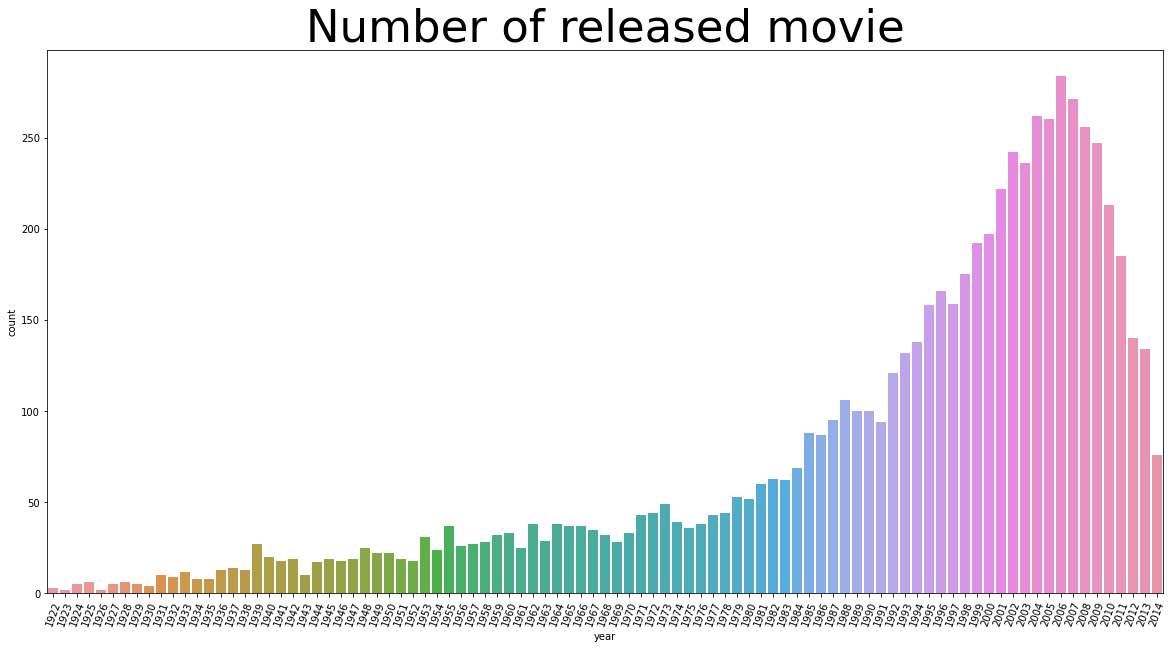

In [35]:
top_n(n=5, df=years_df, col_name='year', title='영화를 가장 많이 개봉한 년도')
min_n(n=5, df=years_df, col_name='year', title='영화를 가장 적게 개봉한 년도')
plot_count(df=years_df, col_name='year', title='Number of released movie')

## 3.2  Directors

- \# of unique directors: 1340
    - 한 영화에 여러명의 감독이 참가한다.
- \# of item have director: 5503
    - 1277개의 item이 director에 대한 정보를 가지고 있지 않다.
- 결측값(null)은 없다.

In [11]:
directors_df = pd.read_csv(os.path.join(train_data_dir, 'directors.tsv'), sep='\t')

directors_df.sample(10)

,item,director
1388,2001,nm0001149
2654,79057,nm0030735
536,36850,nm0000329
4315,27317,nm0586281
3088,58425,nm0213450
1327,5893,nm0001093
1478,27664,nm0001252
1889,3016,nm0001681
3667,272,nm0405336
2880,62081,nm0142286


In [36]:
basic_df_info(directors_df, 'director')
top_n(n=5, df=directors_df, col_name='director', title='영화를 가장 많이 제작한 감독')
min_n(n=5, df=directors_df, col_name='director', title='영화를 가장 적게 제작한 감독')

Number of unique items in director:  5503
Number of unique director:  1340

Missing vluae: 
item        0
director    0
dtype: int64

Statistics of director data: 
count          5905
unique         1340
top       nm0000095
freq             44
Name: director, dtype: object

영화를 가장 많이 제작한 감독 (내림차순): 
 director
nm0000095    44
nm0000033    33
nm0000142    31
nm0000229    29
nm0000217    26
dtype: int64 

영화를 가장 적게 제작한 감독 (내림차순): 
 director
nm0404606    2
nm0405605    2
nm0410139    2
nm0410769    2
nm9054338    2
dtype: int64


## 3.3  Genres

- \# of unique genres: 18
- \# of item have genre: 6807
    - 모든 item이 genre 정보를 가지고 있다.
- 결측값(null)은 없다.

In [13]:
genres_df = pd.read_csv(os.path.join(train_data_dir, 'genres.tsv'), sep='\t')

genres_df.sample(10)

,item,genre
1683,81847,Comedy
4091,4333,Crime
9128,2338,Horror
8063,158,Children
3663,2952,Drama
15684,95105,Adventure
11327,7004,Comedy
1065,2529,Action
1374,596,Children
5413,3729,Action


In [14]:
basic_df_info(genres_df, 'genre')

Number of unique items in genre:  6807
Number of unique genre:  18

Missing vluae: 
item     0
genre    0
dtype: int64

Statistics of genre data: 
count     15933
unique       18
top       Drama
freq       3490
Name: genre, dtype: object



In [15]:
# genres_df.iloc[np.where(genres_df.value_counts(subset='item') > 1)]

가장 많은 영화 장르 (내림차순): 
 genre
Drama       3490
Comedy      2408
Thriller    1466
Romance     1251
Action      1246
dtype: int64 

가장 적은 영화 장르 (내림차순): 
 genre
War            346
Documentary    323
Musical        282
Western        139
Film-Noir       97
dtype: int64


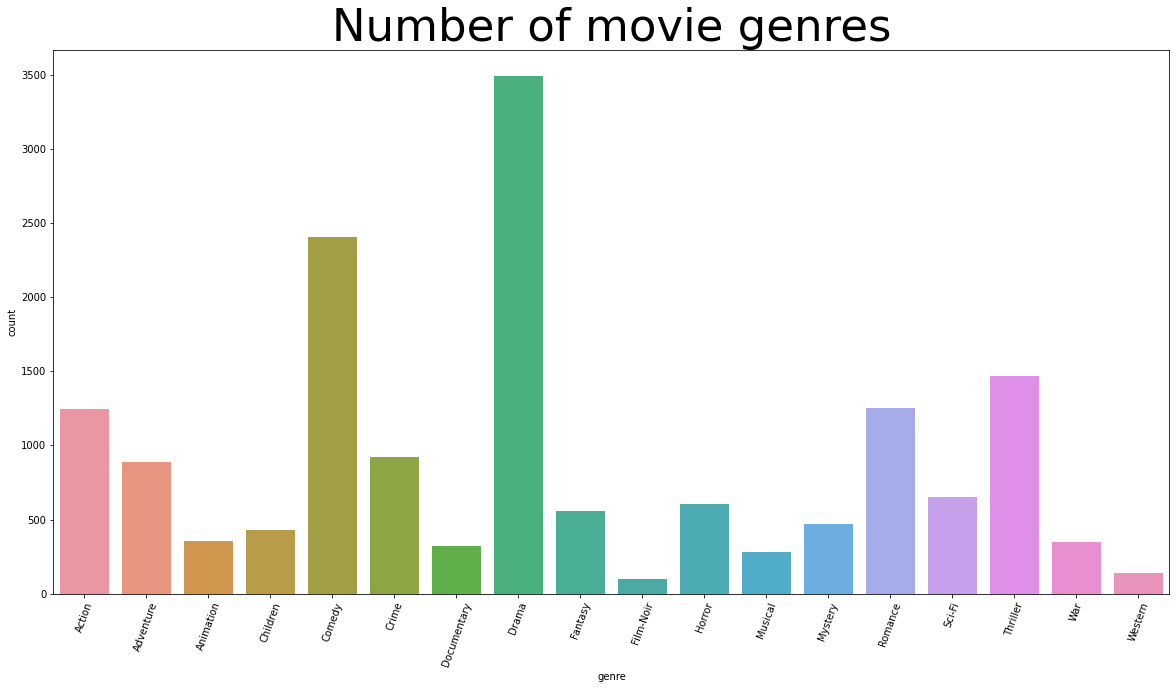

In [39]:
top_n(n=5, df=genres_df, col_name='genre', title='가장 많은 영화 장르')
min_n(n=5, df=genres_df, col_name='genre', title='가장 적은 영화 장르')
plot_count(df=genres_df, col_name='genre', title='Number of movie genres')

## 3.4  Writers

- \# of unique writers: 2989
    - 한 영화에 여러명의 작가가 참가한다.
- \# of item have writers: 5648
    - 1159개의 item이 writer에 대한 정보를 가지고 있지 않다.
- 결측값(null)은 없다.

In [17]:
writers_df = pd.read_csv(os.path.join(train_data_dir, 'writers.tsv'), sep='\t')

writers_df.sample(10)

,item,writer
7327,85316,nm0590316
3408,81018,nm0158984
4739,3988,nm0317450
6433,6516,nm0491306
10961,45668,nm1430632
8372,4386,nm0720135
3187,95105,nm0123666
5875,3179,nm0428630
7438,56744,nm0604948
7229,941,nm0580648


In [18]:
basic_df_info(df=writers_df, col_name='writer')

Number of unique items in writer:  5648
Number of unique writer:  2989

Missing vluae: 
item      0
writer    0
dtype: int64

Statistics of writer data: 
count         11306
unique         2989
top       nm0000095
freq             47
Name: writer, dtype: object



In [40]:
top_n(n=5, df=writers_df, col_name='writer', title="영화를 가장 많이 쓴 작가")
min_n(n=5, df=writers_df, col_name='writer', title="영화를 가장 적게 쓴 작가")

영화를 가장 많이 쓴 작가 (내림차순): 
 writer
nm0000095    47
nm0000636    35
nm0000175    32
nm0372942    30
nm0000108    29
dtype: int64 

영화를 가장 적게 쓴 작가 (내림차순): 
 writer
nm0414893    2
nm0414448    2
nm0414117    2
nm0414047    2
nm5927608    2
dtype: int64


## 3.5 Titles

- \# of unique titles: 6806
    - War of the Worlds (2005)가 중복된다.
- \# of unique items: 6807
- 결측값(null)은 없다.

In [25]:
titles_df = pd.read_csv(os.path.join(train_data_dir, 'titles.tsv'), sep='\t')

titles_df.sample(10)

,item,title
697,44761,Brick (2005)
2330,4009,Talk Radio (1988)
3721,8974,"SpongeBob SquarePants Movie, The (2004)"
4275,65601,My Bloody Valentine 3-D (2009)
934,30822,In Good Company (2004)
6228,46347,Metal: A Headbanger's Journey (2005)
4768,39435,"Legend of Zorro, The (2005)"
2,2959,Fight Club (1999)
883,33154,Enron: The Smartest Guys in the Room (2005)
4201,43904,When a Stranger Calls (2006)


In [26]:
basic_df_info(df=titles_df, col_name='title')

Number of unique items in title:  6807
Number of unique title:  6806

Missing vluae: 
item     0
title    0
dtype: int64

Statistics of title data: 
count                         6807
unique                        6806
top       War of the Worlds (2005)
freq                             2
Name: title, dtype: object



# 4. Merge all side info on item

In [ ]:
# https://stackoverflow.com/questions/59056710/binary-encoding-similar-to-one-hot-encoding-but-where-multiple-values-are-allo

In [ ]:
merge_train = ratings_df.copy()
merge_train['time_date'] = pd.to_datetime(merge_train['time'], unit='s')
merge_train.sample(10)

In [57]:
items_df = pd.DataFrame(ratings_df['item'].unique(), columns=['item'])

dfs = [merge_train, items_df, titles_df, years_df] # genres_df, directors_df, writers_df
merge_df = reduce(lambda left, right: pd.merge(left, right, on='item', how='left'), dfs)

In [58]:
merge_df

,user,item,time,time_date,title,year
0,11,4643,1230782529,2009-01-01 04:02:09,Planet of the Apes (2001),2001.0
1,11,170,1230782534,2009-01-01 04:02:14,Hackers (1995),1995.0
2,11,531,1230782539,2009-01-01 04:02:19,"Secret Garden, The (1993)",1993.0
3,11,616,1230782542,2009-01-01 04:02:22,"Aristocats, The (1970)",1970.0
4,11,2140,1230782563,2009-01-01 04:02:43,"Dark Crystal, The (1982)",1982.0
...,...,...,...,...,...,...
5154466,138493,44022,1260209449,2009-12-07 18:10:49,Ice Age 2: The Meltdown (2006),2006.0
5154467,138493,4958,1260209482,2009-12-07 18:11:22,Behind Enemy Lines (2001),2001.0
5154468,138493,68319,1260209720,2009-12-07 18:15:20,X-Men Origins: Wolverine (2009),2009.0
5154469,138493,40819,1260209726,2009-12-07 18:15:26,Walk the Line (2005),2005.0


맨 처음 평가된 영화는 2005-04-11에 평가되었고, 제일 최근에평가된 영화는 2015-03-31에 평가되었다.

In [63]:
merge_df['time_date'].describe()

/tmp/ipykernel_105235/3190719519.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  merge_df['time_date'].describe()


count                 5154471
unique                5074973
top       2010-02-25 22:00:19
freq                       63
first     2005-04-11 11:56:25
last      2015-03-31 05:50:52
Name: time_date, dtype: object